# PreTrain

In [1]:
from model.sswae_dev2_2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 8
rm = [4,9]

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10 - len(rm)),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [i for i in range(10) if i not in rm]
print("lab:", labeled_class, "rm:", rm)
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, unk=False)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

lab: [0, 1, 2, 3, 5, 6, 7, 8] rm: [4, 9]


In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.228
[2] loss: 0.157
[3] loss: 0.049
[4] loss: 0.025
[5] loss: 0.016
[6] loss: 0.012
[7] loss: 0.008
[8] loss: 0.007
[9] loss: 0.005
[10] loss: 0.008
[11] loss: 0.004
[12] loss: 0.004
[13] loss: 0.004
[14] loss: 0.003
[15] loss: 0.003
[16] loss: 0.002
[17] loss: 0.003
[18] loss: 0.004
[19] loss: 0.003
[20] loss: 0.001


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 8])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

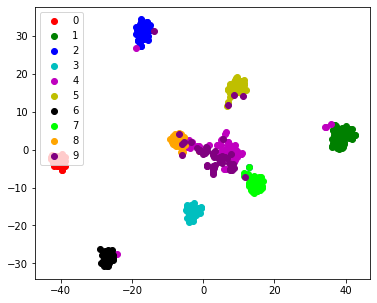

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

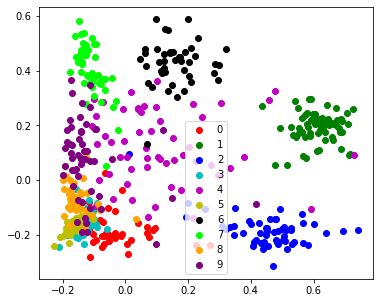

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, class_no = True, unk=False)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10 - len(rm), y_dim))
cs = np.zeros(10 - len(rm))
covs = np.zeros((10 - len(rm), y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10 - len(rm), y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10 - len(rm)):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.0129,  0.6141,  0.4489, -0.1247, -0.1544,  0.1930, -0.1113, -0.1501],
        [ 0.4733, -0.2747, -0.2422, -0.1450, -0.1272,  0.4148, -0.2838,  0.4645],
        [-0.1724,  0.2084, -0.1684, -0.1498, -0.1617,  0.4271,  0.4350, -0.0672],
        [ 0.3570, -0.1723,  0.1210, -0.1937, -0.1127, -0.1645,  0.3008, -0.1429],
        [-0.2254, -0.0751,  0.3922,  0.4609, -0.2355, -0.2423, -0.1563,  0.3621],
        [-0.2584, -0.2821,  0.1880, -0.2421,  0.3312,  0.1933, -0.1595, -0.2056],
        [-0.2443, -0.0407, -0.2885,  0.4344,  0.2651, -0.2235,  0.2093, -0.2833],
        [-0.1496,  0.4949, -0.2004, -0.2201,  0.4352, -0.1799, -0.1726,  0.5145]])

In [13]:
f1 = nn.Linear(10 - len(rm), y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)
w2.shape

torch.Size([8, 8, 8])

In [15]:
for i in range(10 - len(rm)):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10 - len(rm), 1, y_dim, bias=False)
f2.weight.data = w2.view(10 - len(rm), 1, y_dim, y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}.pt')

# Train

In [17]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_rm_4,9.cfg')

['./config/sswae_dev2_rm_4,9.cfg']

In [18]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 8
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,5,6,7,8
[default |INFO|_base_model.py:29] unlabeled_class : 4,9
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] unk : False
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_b

[default |INFO|model.py:1823] [01/80]  loss: 2.593059e-01  D: 6.934852e-01  D2: 5.315546e-02  D3: 3.241753e-03
test loss: 1.914048e-01  D: 6.918959e-01  D2: 3.032665e-02  D3: 6.817633e-03


[default |INFO|model.py:1823] [02/80]  loss: 1.741661e-01  D: 6.943940e-01  D2: 2.162076e-02  D3: 7.140705e-03
test loss: 1.830979e-01  D: 6.932112e-01  D2: 1.360133e-02  D3: 9.386648e-03


[default |INFO|model.py:1823] [03/80]  loss: 1.548263e-01  D: 6.942811e-01  D2: 9.009597e-03  D3: 7.018611e-03
test loss: 1.407042e-01  D: 6.904370e-01  D2: 3.430482e-03  D3: 7.571700e-03


[default |INFO|model.py:1823] [04/80]  loss: 1.340703e-01  D: 6.941306e-01  D2: 3.188557e-04  D3: 1.042514e-02
test loss: 1.261682e-01  D: 7.200356e-01  D2: -3.742327e-04  D3: 1.007359e-02


[default |INFO|model.py:1823] [05/80]  loss: 1.381780e-01  D: 7.494539e-01  D2: -7.794349e-04  D3: 1.440924e-02
test loss: 1.160384e-01  D: 7.127743e-01  D2: -1.809414e-03  D3: 8.358799e-03


[default |INFO|model.py:1823] [06/80]  loss: 1.061825e-01  D: 7.034770e-01  D2: -2.056193e-03  D3: 9.011346e-03
test loss: 9.896435e-02  D: 7.034251e-01  D2: -2.903470e-03  D3: 1.185172e-02


[default |INFO|model.py:1823] [07/80]  loss: 9.403921e-02  D: 6.903815e-01  D2: -3.081911e-03  D3: 1.296955e-02
test loss: 8.924278e-02  D: 6.969135e-01  D2: -3.904494e-03  D3: 1.280808e-02


[default |INFO|model.py:1823] [08/80]  loss: 8.789322e-02  D: 6.945913e-01  D2: -3.638361e-03  D3: 1.493493e-02
test loss: 8.611943e-02  D: 7.023255e-01  D2: -3.851001e-03  D3: 1.497353e-02


[default |INFO|model.py:1823] [09/80]  loss: 8.101629e-02  D: 6.943935e-01  D2: -3.982465e-03  D3: 1.353988e-02
test loss: 7.867923e-02  D: 6.981952e-01  D2: -3.415759e-03  D3: 1.374270e-02


[default |INFO|model.py:1823] [10/80]  loss: 7.908453e-02  D: 6.926439e-01  D2: -4.316967e-03  D3: 1.537096e-02
test loss: 7.652042e-02  D: 7.012510e-01  D2: -4.671581e-03  D3: 1.449524e-02


[default |INFO|model.py:1823] [11/80]  loss: 7.475511e-02  D: 6.938280e-01  D2: -4.800413e-03  D3: 1.355283e-02
test loss: 7.234145e-02  D: 6.836267e-01  D2: -5.370062e-03  D3: 1.402238e-02


[default |INFO|model.py:1823] [12/80]  loss: 7.092782e-02  D: 6.937491e-01  D2: -4.862400e-03  D3: 1.414338e-02
test loss: 7.062154e-02  D: 7.124292e-01  D2: -4.271944e-03  D3: 1.456662e-02


[default |INFO|model.py:1823] [13/80]  loss: 6.836555e-02  D: 6.935087e-01  D2: -4.902230e-03  D3: 1.463591e-02
test loss: 6.602149e-02  D: 6.797269e-01  D2: -5.738221e-03  D3: 1.453319e-02


[default |INFO|model.py:1823] [14/80]  loss: 6.591004e-02  D: 6.932148e-01  D2: -5.482680e-03  D3: 1.415287e-02
test loss: 6.612933e-02  D: 6.888045e-01  D2: -4.818399e-03  D3: 1.411352e-02


[default |INFO|model.py:1823] [15/80]  loss: 6.476713e-02  D: 6.932204e-01  D2: -5.555934e-03  D3: 1.423296e-02
test loss: 6.581900e-02  D: 6.883370e-01  D2: -5.216272e-03  D3: 1.482274e-02


[default |INFO|model.py:1823] [16/80]  loss: 6.300506e-02  D: 6.927822e-01  D2: -5.677294e-03  D3: 1.418617e-02
test loss: 6.256237e-02  D: 6.800786e-01  D2: -5.384114e-03  D3: 1.503274e-02


[default |INFO|model.py:1823] [17/80]  loss: 6.154929e-02  D: 6.930869e-01  D2: -5.829057e-03  D3: 1.406355e-02
test loss: 6.075804e-02  D: 6.954739e-01  D2: -5.723036e-03  D3: 1.449572e-02


[default |INFO|model.py:1823] [18/80]  loss: 6.003443e-02  D: 6.931539e-01  D2: -6.171814e-03  D3: 1.385528e-02
test loss: 6.102500e-02  D: 6.991929e-01  D2: -5.898485e-03  D3: 1.360099e-02


[default |INFO|model.py:1823] [19/80]  loss: 5.895153e-02  D: 6.931001e-01  D2: -6.308912e-03  D3: 1.371672e-02
test loss: 5.958378e-02  D: 7.002585e-01  D2: -5.800809e-03  D3: 1.391103e-02


[default |INFO|model.py:1823] [20/80]  loss: 5.795356e-02  D: 6.928319e-01  D2: -6.348357e-03  D3: 1.345246e-02
test loss: 5.832498e-02  D: 6.888853e-01  D2: -6.777965e-03  D3: 1.381479e-02


[default |INFO|model.py:1823] [21/80]  loss: 5.869403e-02  D: 6.946268e-01  D2: -6.271643e-03  D3: 1.307477e-02
test loss: 5.966701e-02  D: 6.892631e-01  D2: -6.757578e-03  D3: 1.382399e-02


[default |INFO|model.py:1823] [22/80]  loss: 5.874492e-02  D: 6.920598e-01  D2: -6.599296e-03  D3: 1.346198e-02
test loss: 5.845334e-02  D: 7.048128e-01  D2: -7.141702e-03  D3: 1.263365e-02


[default |INFO|model.py:1823] [23/80]  loss: 5.753308e-02  D: 6.937651e-01  D2: -6.682159e-03  D3: 1.310030e-02
test loss: 5.724211e-02  D: 6.919166e-01  D2: -6.914587e-03  D3: 1.221506e-02


[default |INFO|model.py:1823] [24/80]  loss: 5.620394e-02  D: 6.928932e-01  D2: -6.764105e-03  D3: 1.337091e-02
test loss: 5.757495e-02  D: 6.957860e-01  D2: -7.039642e-03  D3: 1.387116e-02


[default |INFO|model.py:1823] [25/80]  loss: 5.521406e-02  D: 6.930573e-01  D2: -7.002631e-03  D3: 1.318275e-02
test loss: 5.459669e-02  D: 6.873991e-01  D2: -7.198163e-03  D3: 1.294033e-02


[default |INFO|model.py:1823] [26/80]  loss: 5.486243e-02  D: 6.933307e-01  D2: -7.144987e-03  D3: 1.307038e-02
test loss: 5.801852e-02  D: 7.005702e-01  D2: -7.547171e-03  D3: 1.356458e-02


[default |INFO|model.py:1823] [27/80]  loss: 5.462233e-02  D: 6.928775e-01  D2: -6.986021e-03  D3: 1.302969e-02
test loss: 5.537980e-02  D: 6.967551e-01  D2: -7.894351e-03  D3: 1.207977e-02


[default |INFO|model.py:1823] [28/80]  loss: 5.414455e-02  D: 6.930145e-01  D2: -7.474551e-03  D3: 1.276190e-02
test loss: 5.524521e-02  D: 6.856716e-01  D2: -6.824679e-03  D3: 1.319095e-02


[default |INFO|model.py:1823] [29/80]  loss: 5.446251e-02  D: 6.928883e-01  D2: -7.331130e-03  D3: 1.274112e-02
test loss: 5.609002e-02  D: 6.868896e-01  D2: -7.285607e-03  D3: 1.264090e-02


[default |INFO|model.py:1823] [30/80]  loss: 5.499769e-02  D: 6.939842e-01  D2: -7.440941e-03  D3: 1.254304e-02
test loss: 5.479197e-02  D: 6.900372e-01  D2: -7.875148e-03  D3: 1.107189e-02


[default |INFO|model.py:1823] [31/80]  loss: 5.556170e-02  D: 6.935049e-01  D2: -7.396273e-03  D3: 1.239083e-02
test loss: 5.604952e-02  D: 6.794069e-01  D2: -7.496122e-03  D3: 1.243387e-02


[default |INFO|model.py:1823] [32/80]  loss: 5.454609e-02  D: 6.939831e-01  D2: -7.717516e-03  D3: 1.248389e-02
test loss: 5.535331e-02  D: 6.989473e-01  D2: -7.465650e-03  D3: 1.342504e-02


[default |INFO|model.py:1823] [33/80]  loss: 5.339363e-02  D: 6.932585e-01  D2: -7.562073e-03  D3: 1.261678e-02
test loss: 5.563759e-02  D: 6.939737e-01  D2: -7.566318e-03  D3: 1.158501e-02


[default |INFO|model.py:1823] [34/80]  loss: 5.329769e-02  D: 6.938173e-01  D2: -7.726159e-03  D3: 1.269802e-02
test loss: 5.554818e-02  D: 6.826041e-01  D2: -8.346415e-03  D3: 1.307817e-02


[default |INFO|model.py:1823] [35/80]  loss: 5.258040e-02  D: 6.933648e-01  D2: -8.074337e-03  D3: 1.236636e-02
test loss: 5.438747e-02  D: 6.938376e-01  D2: -8.436232e-03  D3: 1.208975e-02


[default |INFO|model.py:1823] [36/80]  loss: 5.129465e-02  D: 6.930505e-01  D2: -8.117644e-03  D3: 1.267619e-02
test loss: 5.133069e-02  D: 7.041198e-01  D2: -8.348527e-03  D3: 1.277258e-02


[default |INFO|model.py:1823] [37/80]  loss: 5.105037e-02  D: 6.932885e-01  D2: -8.183826e-03  D3: 1.258697e-02
test loss: 5.410738e-02  D: 6.783376e-01  D2: -8.431419e-03  D3: 1.200604e-02


[default |INFO|model.py:1823] [38/80]  loss: 5.105084e-02  D: 6.932554e-01  D2: -8.268974e-03  D3: 1.260125e-02
test loss: 5.158156e-02  D: 7.022725e-01  D2: -7.927080e-03  D3: 1.311800e-02


[default |INFO|model.py:1823] [39/80]  loss: 5.050436e-02  D: 6.934592e-01  D2: -8.306357e-03  D3: 1.246395e-02
test loss: 5.353094e-02  D: 6.864877e-01  D2: -8.117150e-03  D3: 1.236337e-02


[default |INFO|model.py:1823] [40/80]  loss: 5.056734e-02  D: 6.936072e-01  D2: -8.443358e-03  D3: 1.260599e-02
test loss: 5.307563e-02  D: 7.042349e-01  D2: -8.392363e-03  D3: 1.275659e-02


[default |INFO|model.py:1823] [41/80]  loss: 5.065219e-02  D: 6.929024e-01  D2: -8.438415e-03  D3: 1.240136e-02
test loss: 5.175882e-02  D: 6.914068e-01  D2: -8.057079e-03  D3: 1.230903e-02


[default |INFO|model.py:1823] [42/80]  loss: 5.084700e-02  D: 6.939569e-01  D2: -8.572028e-03  D3: 1.230715e-02
test loss: 5.282361e-02  D: 6.911377e-01  D2: -8.908880e-03  D3: 1.194088e-02


[default |INFO|model.py:1823] [43/80]  loss: 5.049774e-02  D: 6.938051e-01  D2: -8.704526e-03  D3: 1.215715e-02
test loss: 5.111054e-02  D: 6.908416e-01  D2: -8.831027e-03  D3: 1.348677e-02


[default |INFO|model.py:1823] [44/80]  loss: 5.055387e-02  D: 6.929860e-01  D2: -8.608236e-03  D3: 1.217481e-02
test loss: 5.164106e-02  D: 7.043499e-01  D2: -8.624690e-03  D3: 1.303368e-02


[default |INFO|model.py:1823] [45/80]  loss: 5.031887e-02  D: 6.930185e-01  D2: -8.785901e-03  D3: 1.200718e-02
test loss: 5.195377e-02  D: 6.813017e-01  D2: -8.932066e-03  D3: 1.130435e-02


[default |INFO|model.py:1823] [46/80]  loss: 4.960391e-02  D: 6.934784e-01  D2: -8.818640e-03  D3: 1.198630e-02
test loss: 5.200980e-02  D: 6.904807e-01  D2: -9.025470e-03  D3: 1.178171e-02


[default |INFO|model.py:1823] [47/80]  loss: 5.009198e-02  D: 6.935051e-01  D2: -8.899530e-03  D3: 1.223340e-02
test loss: 5.133059e-02  D: 6.943958e-01  D2: -9.094958e-03  D3: 1.099302e-02


[default |INFO|model.py:1823] [48/80]  loss: 4.999226e-02  D: 6.934613e-01  D2: -8.940768e-03  D3: 1.199074e-02
test loss: 5.207014e-02  D: 6.891881e-01  D2: -9.294881e-03  D3: 1.170966e-02


[default |INFO|model.py:1823] [49/80]  loss: 4.918671e-02  D: 6.931127e-01  D2: -8.990333e-03  D3: 1.220122e-02
test loss: 5.106953e-02  D: 6.978670e-01  D2: -9.214726e-03  D3: 1.156312e-02


[default |INFO|model.py:1823] [50/80]  loss: 4.848566e-02  D: 6.933591e-01  D2: -9.095722e-03  D3: 1.217865e-02
test loss: 5.053559e-02  D: 6.899244e-01  D2: -9.145671e-03  D3: 1.229281e-02


[default |INFO|model.py:1823] [51/80]  loss: 4.843490e-02  D: 6.933525e-01  D2: -9.142850e-03  D3: 1.215235e-02
test loss: 5.222887e-02  D: 6.919743e-01  D2: -9.211377e-03  D3: 1.290354e-02


[default |INFO|model.py:1823] [52/80]  loss: 4.889517e-02  D: 6.933427e-01  D2: -9.114222e-03  D3: 1.191350e-02
test loss: 5.107858e-02  D: 6.920828e-01  D2: -9.380847e-03  D3: 1.196379e-02


[default |INFO|model.py:1823] [53/80]  loss: 4.881888e-02  D: 6.940095e-01  D2: -9.235040e-03  D3: 1.193552e-02
test loss: 5.400940e-02  D: 6.923833e-01  D2: -9.470451e-03  D3: 1.233471e-02


[default |INFO|model.py:1823] [54/80]  loss: 4.887440e-02  D: 6.928523e-01  D2: -9.324325e-03  D3: 1.188104e-02
test loss: 5.002592e-02  D: 7.002445e-01  D2: -9.412725e-03  D3: 1.092176e-02


[default |INFO|model.py:1823] [55/80]  loss: 4.822048e-02  D: 6.930419e-01  D2: -9.277316e-03  D3: 1.206508e-02
test loss: 4.905620e-02  D: 6.958124e-01  D2: -9.552800e-03  D3: 1.249722e-02


[default |INFO|model.py:1823] [56/80]  loss: 4.765468e-02  D: 6.937256e-01  D2: -9.336044e-03  D3: 1.186560e-02
test loss: 4.918052e-02  D: 6.993059e-01  D2: -9.277008e-03  D3: 1.242074e-02


[default |INFO|model.py:1823] [57/80]  loss: 4.741366e-02  D: 6.929306e-01  D2: -9.364995e-03  D3: 1.194724e-02
test loss: 5.076858e-02  D: 6.946218e-01  D2: -9.109507e-03  D3: 1.105257e-02


[default |INFO|model.py:1823] [58/80]  loss: 4.697454e-02  D: 6.934786e-01  D2: -9.459596e-03  D3: 1.203173e-02
test loss: 4.978140e-02  D: 6.907948e-01  D2: -9.848639e-03  D3: 1.188137e-02


[default |INFO|model.py:1823] [59/80]  loss: 4.781814e-02  D: 6.932449e-01  D2: -9.428564e-03  D3: 1.185203e-02
test loss: 5.158791e-02  D: 6.978485e-01  D2: -9.624481e-03  D3: 1.142352e-02


[default |INFO|model.py:1823] [60/80]  loss: 4.800704e-02  D: 6.937756e-01  D2: -9.481442e-03  D3: 1.157992e-02
test loss: 5.103671e-02  D: 6.919388e-01  D2: -9.478012e-03  D3: 1.259470e-02


[default |INFO|model.py:1823] [61/80]  loss: 4.718007e-02  D: 6.932304e-01  D2: -9.445442e-03  D3: 1.190115e-02
test loss: 5.008246e-02  D: 6.988197e-01  D2: -9.446013e-03  D3: 1.142046e-02


[default |INFO|model.py:1823] [62/80]  loss: 4.705904e-02  D: 6.938161e-01  D2: -9.509306e-03  D3: 1.187430e-02
test loss: 4.869868e-02  D: 7.044930e-01  D2: -9.526033e-03  D3: 1.257132e-02


[default |INFO|model.py:1823] [63/80]  loss: 4.755614e-02  D: 6.931775e-01  D2: -9.548613e-03  D3: 1.168400e-02
test loss: 4.849067e-02  D: 6.925940e-01  D2: -9.908300e-03  D3: 1.258066e-02


[default |INFO|model.py:1823] [64/80]  loss: 4.679458e-02  D: 6.936067e-01  D2: -9.530710e-03  D3: 1.187355e-02
test loss: 4.843574e-02  D: 6.910731e-01  D2: -9.564661e-03  D3: 1.200556e-02


[default |INFO|model.py:1823] [65/80]  loss: 4.725411e-02  D: 6.931622e-01  D2: -9.530724e-03  D3: 1.178213e-02
test loss: 4.923161e-02  D: 6.926276e-01  D2: -9.741003e-03  D3: 1.090815e-02


[default |INFO|model.py:1823] [66/80]  loss: 4.662837e-02  D: 6.934133e-01  D2: -9.596726e-03  D3: 1.164472e-02
test loss: 4.882496e-02  D: 6.956851e-01  D2: -9.630560e-03  D3: 1.088736e-02


[default |INFO|model.py:1823] [67/80]  loss: 4.670741e-02  D: 6.934829e-01  D2: -9.637815e-03  D3: 1.171802e-02
test loss: 4.872569e-02  D: 7.077422e-01  D2: -9.817259e-03  D3: 1.339154e-02


[default |INFO|model.py:1823] [68/80]  loss: 4.633719e-02  D: 6.933092e-01  D2: -9.605548e-03  D3: 1.175124e-02
test loss: 4.860674e-02  D: 7.031453e-01  D2: -9.907522e-03  D3: 1.204897e-02


[default |INFO|model.py:1823] [69/80]  loss: 4.608189e-02  D: 6.933898e-01  D2: -9.718375e-03  D3: 1.158626e-02
test loss: 4.957323e-02  D: 6.914736e-01  D2: -9.853462e-03  D3: 1.150466e-02


[default |INFO|model.py:1823] [70/80]  loss: 4.611383e-02  D: 6.933717e-01  D2: -9.608619e-03  D3: 1.162007e-02
test loss: 4.928081e-02  D: 6.976265e-01  D2: -9.910448e-03  D3: 1.191048e-02


[default |INFO|model.py:1823] [71/80]  loss: 4.702871e-02  D: 6.938252e-01  D2: -9.656989e-03  D3: 1.145263e-02
test loss: 4.903335e-02  D: 6.847969e-01  D2: -9.791063e-03  D3: 1.153942e-02


[default |INFO|model.py:1823] [72/80]  loss: 4.560544e-02  D: 6.932248e-01  D2: -9.761177e-03  D3: 1.163250e-02
test loss: 4.868082e-02  D: 6.935320e-01  D2: -9.866296e-03  D3: 1.178841e-02


[default |INFO|model.py:1823] [73/80]  loss: 4.571596e-02  D: 6.931714e-01  D2: -9.774996e-03  D3: 1.160143e-02
test loss: 4.977440e-02  D: 6.947283e-01  D2: -1.008658e-02  D3: 1.015543e-02


[default |INFO|model.py:1823] [74/80]  loss: 4.601634e-02  D: 6.936880e-01  D2: -9.765360e-03  D3: 1.145088e-02
test loss: 4.844663e-02  D: 6.923465e-01  D2: -1.006446e-02  D3: 1.113426e-02


[default |INFO|model.py:1823] [75/80]  loss: 4.600500e-02  D: 6.933952e-01  D2: -9.828821e-03  D3: 1.149824e-02
test loss: 4.845821e-02  D: 6.942597e-01  D2: -1.013322e-02  D3: 9.871479e-03


[default |INFO|model.py:1823] [76/80]  loss: 4.590073e-02  D: 6.931189e-01  D2: -9.739898e-03  D3: 1.149528e-02
test loss: 4.871905e-02  D: 6.886283e-01  D2: -9.844513e-03  D3: 1.157638e-02


[default |INFO|model.py:1823] [77/80]  loss: 4.534892e-02  D: 6.930725e-01  D2: -9.777312e-03  D3: 1.156814e-02
test loss: 4.868144e-02  D: 6.875566e-01  D2: -9.783389e-03  D3: 1.075637e-02


[default |INFO|model.py:1823] [78/80]  loss: 4.554519e-02  D: 6.930946e-01  D2: -9.841569e-03  D3: 1.145045e-02
test loss: 4.960355e-02  D: 6.975563e-01  D2: -9.870644e-03  D3: 1.242826e-02


[default |INFO|model.py:1823] [79/80]  loss: 4.541638e-02  D: 6.939607e-01  D2: -9.794200e-03  D3: 1.152137e-02
test loss: 4.868480e-02  D: 6.969561e-01  D2: -9.452554e-03  D3: 1.216540e-02


[default |INFO|model.py:1823] [80/80]  loss: 4.523531e-02  D: 6.928489e-01  D2: -9.818694e-03  D3: 1.146140e-02
test loss: 4.805125e-02  D: 6.909053e-01  D2: -1.017321e-02  D3: 1.114128e-02


[default |INFO|model.py:1938] Training Finished!
[default |INFO|model.py:1939] Elapsed time: 2470.605s


# Test

In [19]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [20]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [21]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[-i])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

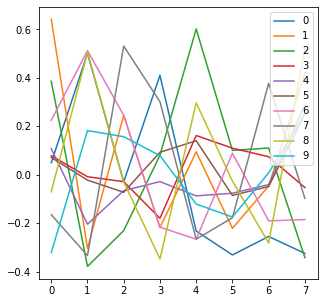

In [22]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

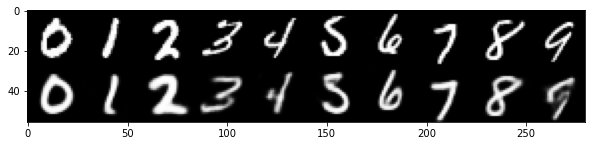

In [23]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [24]:
from XAE.sampler import gaus

exn = 5

In [25]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

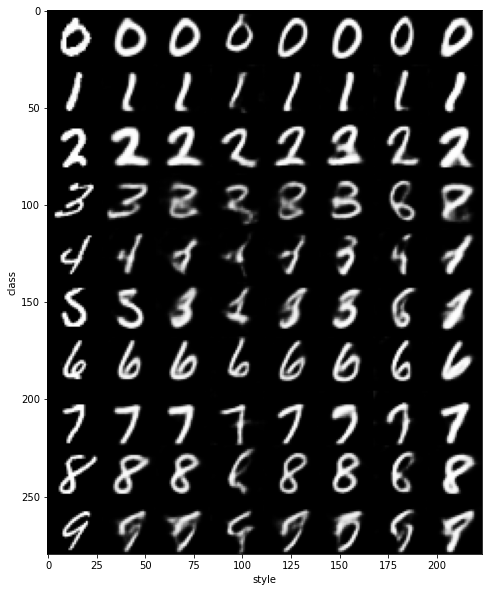

In [26]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [27]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

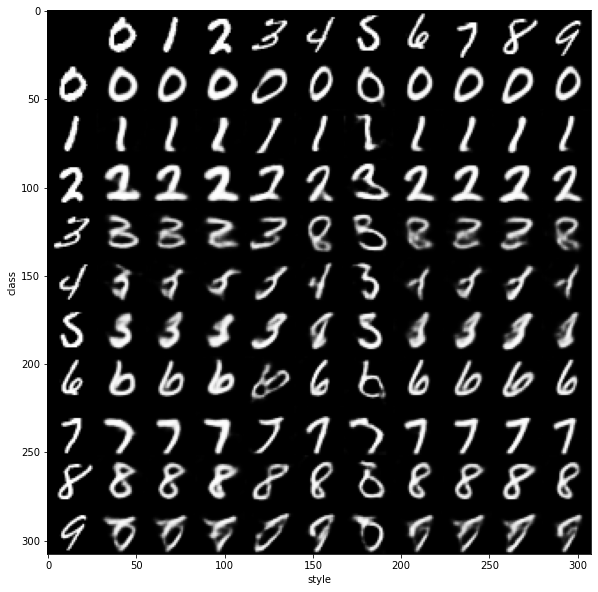

In [28]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()